# Gerador de Música

Este notebook foi criado com o objetivo de criar um gerador de música utilizando os passos apresentados [neste artigo](https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/).

## Bibliotecas

In [1]:
import requests
import os
import random
from music21 import *
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.models import load_model
from keras.layers import BatchNormalization as BatchNorm

2022-03-18 16:14:55.132426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 16:14:55.133187: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Infelizmente os arquivos do artigo mencionado não estão mais disponíveis, mas eu encontrei um site que possui uma base de dados com um escopo similar, que pode nos ajudar a obter resultados bons também. Como são muitos arquivos para fazer o download, então eu irei utilizar o beautifulsoup para poder realizar o download de todos os arquivos de maneira rápida

In [2]:
# acessar o html da pagina pelo bs4
# obter o url dos arquivos mid a partir do html
html = urlopen("https://www.audiolabs-erlangen.de/resources/MIR/SMD/midi")
bs = BeautifulSoup(html, 'html.parser')
urls = []
names = []
for i, link in enumerate(bs.findAll("a")):
    if link.get("href").endswith("mid"):
        urls.append(link.get("href"))


for i in range(len(urls)):
    names.append(urls[i].split('/')[-1:])
# realizar o download dos arquivos mid utilizando as url obtidas no passo anterior


In [3]:
for i in range(len(urls)):
    r = requests.get(urls[i])
    name = urls[i].split('/')[-1:][0]
    
    open('./musicas/'+ name, 'wb').write(r.content)

Com os arquivos devidamente baixados, agora definiremos uma função que irá ler os arquivos mid

In [2]:
def read_midi(file):
    print("Carregando arquivos de música: ", file)
    
    notes = []
    notes_to_parse = None
    
    # analisando um arquivo midi
    
    midi = converter.parse(file)
    
    # agrupando baseado em diferentes instrumentos
    s2 = instrument.partitionByInstrument(midi)
    
    # Realizando o loop sobre todos os instrumentos
    for part in s2.parts:
        
        # selecionando os elementos de um único piano
#         if 'Piano' in str(part):
        notes_to_parse = part.recurse()

        # Encontrando se um particular elemento é uma nota ou um acorde
        for element in notes_to_parse:
            # notas
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))

            if isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
                    
    return np.array(notes)

Agora, iremos carregar os arquivos MIDI no nosso ambiente

In [5]:
path = './musicas/'


# lendo o nome de todos os arquivos
files = [i for i in os.listdir(path) if i.endswith(".mid")]

# lendo cada arquivo mid
notes_array = np.array([read_midi(path+i) for i in files])


Carregando arquivos de música:  ./musicas/Chopin_Op028-17_005_20100611-SMD.mid
Carregando arquivos de música:  ./musicas/Bach_BWV875-02_002_20090916-SMD.mid
Carregando arquivos de música:  ./musicas/Brahms_Op010No1_003_20090916-SMD.mid
Carregando arquivos de música:  ./musicas/Bach_BWV849-01_001_20090916-SMD.mid
Carregando arquivos de música:  ./musicas/Chopin_Op026No2_005_20100611-SMD.mid
Carregando arquivos de música:  ./musicas/Chopin_Op029_004_20100611-SMD.mid
Carregando arquivos de música:  ./musicas/Beethoven_Op031No2-03_002_20090916-SMD.mid
Carregando arquivos de música:  ./musicas/Bartok_SZ080-01_002_20110315-SMD.mid
Carregando arquivos de música:  ./musicas/Liszt_VariationenBachmotivWeinenKlagenSorgenZagen_001_20090916-SMD.mid
Carregando arquivos de música:  ./musicas/Bach_BWV888-01_008_20110315-SMD.mid
Carregando arquivos de música:  ./musicas/Bartok_SZ080-02_002_20110315-SMD.mid
Carregando arquivos de música:  ./musicas/Rachmaninoff_Op036-02_007_20110315-SMD.mid
Carregando a

/tmp/ipykernel_61414/1460871410.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  notes_array = np.array([read_midi(path+i) for i in files])


### Entendendo os dados

Nesta seção, iremos explorar o conjunto de dados e entendê-lo em mais detalhes

In [6]:
notes_ = [element for note_ in notes_array for element in note_]
unique_notes = list(set(notes_))

print(len(unique_notes))

1219


Como você pode ver, o número de notas únicas é 1219. Agora vejamos a distribuição das notas.

(array([1.084e+03, 4.300e+01, 3.900e+01, 2.300e+01, 8.000e+00, 9.000e+00,
        8.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([1.0000e+00, 1.6260e+02, 3.2420e+02, 4.8580e+02, 6.4740e+02,
        8.0900e+02, 9.7060e+02, 1.1322e+03, 1.2938e+03, 1.4554e+03,
        1.6170e+03]),
 <BarContainer object of 10 artists>)

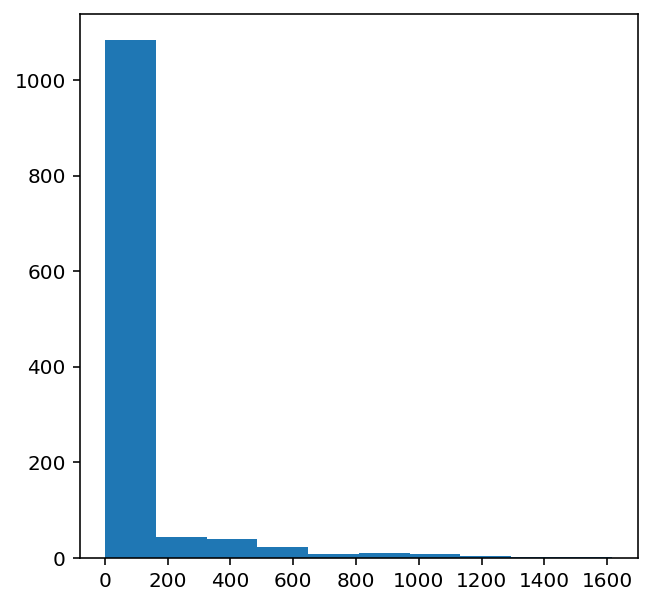

In [7]:
freq = dict(Counter(notes_))

no = [count for _, count in freq.items()]

plt.figure(figsize=(5,5))

plt.hist(no)

Do histograma acima, podemos notar que a maioria das notas ocorrem com pouquíssima frequência. Então, podemos apenas manter as notas com maior frequência e ignorar as demais. Vamos utilizar apenas as que possuem frequência igual ou acima de 50,

In [8]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

204


Como podemos ver aqui, o número de notas que com frequência maior ou igual a 50 é 204. Agora vamos preparar novos arquivos de música que irão conter apenas as notas mais frequentes

In [9]:
new_music = []

for notes in notes_array:
    temp = []
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)
    new_music.append(temp)
    
    
new_music = np.array(new_music)

/tmp/ipykernel_61414/1226839680.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_music = np.array(new_music)


### Preparando os dados:

Para entender como os dados devem ser preparados, devemos entender como o modelo será estruturado.

Imagine que temos um trecho de áudio de 5 segundos com uma taxa de 16 mil amostras por segundo, isso dará no total 80 mil amostras ao longo de todo o trecho do áudio. Se quebrarmos todo o áudio em pedaços iguais de 1024 amostras, podemos alimentar uma rede neural com estas amostras, de modo que a rede neural possa prever qual seria o valor da amostra n° 1025, por exemplo.

Esse processo é chamado de **autoregressivo**, portanto, o modelo a utilizá-lo é conhecido como **modelo autoregressivo**.

Tendo esses passos esclarecidos, podemos então definir como funcionará o processo de inferência que será utilizado para construir a música. Consideremos do exemplo anterior, que as amostras dívididas em "pedaços", são armazenadas, na realidade, em vetores. Com isso, os passos serão:
1. Selecionar um vetor de amostras como ponto de partida do modelo;
- Inicialmente, iremos criar a coleção de vetores de amostras, sorteando dentro desta coleção um vetor em específico para que o modelo faça a previsão.
2. O modelo irá gerar como saída uma distribuição de probabilidade para cada amostra;
3. A amostra com a maior probabilidade será escolhida e anexada em um novo vetor de amostras;
4. Deleta o primeiro elemento e passa o valor previsto como entrada para a próxima iteração;
5. Repete o processo dos passos 2 ao 4 por um dado número de iterações


In [37]:
no_of_timesteps = 70

x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        # preparando as sequências de entrada e saída:
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        
        x.append(input_)
        y.append(output)
        
x = np.array(x)
y = np.array(y)

Agora, iremos atribuir um único inteiro para cada nota:

In [38]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

Iremos preparara a sequência de dados de entrada

In [39]:
x_seq = []

for i in x:
    temp = []
    
    for j in i:
        # atrinbuindo um inteiro único para cada nota
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

De maneira similar, realizamos o mesmo procedimento agora para os dados de saída

In [40]:
unique_y = list(set(y))
y_note_to_int = dict((note_,number) for number, note_ in enumerate(unique_y))
y_seq = np.array([y_note_to_int[i] for i in y])

Iremos preservar apenas 80% dos dados de treinamento e os outros 20% serão utilizados para avaliação

In [41]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq, y_seq, test_size=0.2, random_state=0)

## Aplicação dos Modelos

### Modelo WaveNet

Definindo a arquitetura WaveNet

In [18]:
K.clear_session()

model = Sequential()

model.add(Embedding(len(unique_x), 100, input_length=32, trainable=True))

model.add(Conv1D(64, 3, padding='causal', activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool1D(2))

model.add(Conv1D(128, 3, activation='relu', dilation_rate=2, padding='causal'))
model.add(Dropout(0.1))
model.add(MaxPool1D(2))

model.add(Conv1D(256, 3, activation='relu', dilation_rate=4, padding='causal'))
model.add(Dropout(0.1))
model.add(MaxPool1D(2))

model.add(GlobalMaxPool1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           20400     
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

2022-03-16 23:27:53.178579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 23:27:53.178615: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 23:27:53.178639: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lucas-Inspiron-5566): /proc/driver/nvidia/version does not exist
2022-03-16 23:27:53.178856: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Definindo o callback para salvar o melhor modelo durante o treinamento:

In [19]:
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

Vamos treinar o modelo com o batch size de 64 para 100 épocas

In [20]:
history = model.fit(np.array(x_tr), np.array(y_tr), batch_size=64, epochs=100,
                   validation_data=(np.array(x_val), np.array(y_val)), verbose=1,
                   callbacks=[mc])

Epoch 1/100
913/913 [==============================] - ETA: 0s - loss: 4.8088
Epoch 1: val_loss improved from inf to 4.71754, saving model to best_model.h5
913/913 [==============================] - 23s 24ms/step - loss: 4.8088 - val_loss: 4.7175
Epoch 2/100
911/913 [============================>.] - ETA: 0s - loss: 4.5410
Epoch 2: val_loss improved from 4.71754 to 4.45842, saving model to best_model.h5
913/913 [==============================] - 22s 24ms/step - loss: 4.5409 - val_loss: 4.4584
Epoch 3/100
911/913 [============================>.] - ETA: 0s - loss: 4.3404
Epoch 3: val_loss improved from 4.45842 to 4.33443, saving model to best_model.h5
913/913 [==============================] - 22s 24ms/step - loss: 4.3403 - val_loss: 4.3344
Epoch 4/100
911/913 [============================>.] - ETA: 0s - loss: 4.2298
Epoch 4: val_loss improved from 4.33443 to 4.28926, saving model to best_model.h5
913/913 [==============================] - 22s 25ms/step - loss: 4.2301 - val_loss: 4.2893


Epoch 37/100
913/913 [==============================] - ETA: 0s - loss: 3.1726
Epoch 37: val_loss did not improve from 4.10276
913/913 [==============================] - 22s 24ms/step - loss: 3.1726 - val_loss: 4.2777
Epoch 38/100
913/913 [==============================] - ETA: 0s - loss: 3.1717
Epoch 38: val_loss did not improve from 4.10276
913/913 [==============================] - 22s 24ms/step - loss: 3.1717 - val_loss: 4.2573
Epoch 39/100
912/913 [============================>.] - ETA: 0s - loss: 3.1639
Epoch 39: val_loss did not improve from 4.10276
913/913 [==============================] - 22s 24ms/step - loss: 3.1639 - val_loss: 4.2668
Epoch 40/100
913/913 [==============================] - ETA: 0s - loss: 3.1576
Epoch 40: val_loss did not improve from 4.10276
913/913 [==============================] - 22s 24ms/step - loss: 3.1576 - val_loss: 4.2721
Epoch 41/100
913/913 [==============================] - ETA: 0s - loss: 3.1455
Epoch 41: val_loss did not improve from 4.10276
9

913/913 [==============================] - 19s 21ms/step - loss: 2.9631 - val_loss: 4.3897
Epoch 75/100
911/913 [============================>.] - ETA: 0s - loss: 2.9468
Epoch 75: val_loss did not improve from 4.10276
913/913 [==============================] - 19s 21ms/step - loss: 2.9466 - val_loss: 4.4480
Epoch 76/100
912/913 [============================>.] - ETA: 0s - loss: 2.9494
Epoch 76: val_loss did not improve from 4.10276
913/913 [==============================] - 19s 21ms/step - loss: 2.9495 - val_loss: 4.4298
Epoch 77/100
911/913 [============================>.] - ETA: 0s - loss: 2.9481
Epoch 77: val_loss did not improve from 4.10276
913/913 [==============================] - 21s 23ms/step - loss: 2.9484 - val_loss: 4.4236
Epoch 78/100
911/913 [============================>.] - ETA: 0s - loss: 2.9464
Epoch 78: val_loss did not improve from 4.10276
913/913 [==============================] - 20s 21ms/step - loss: 2.9465 - val_loss: 4.4140
Epoch 79/100
910/913 [===============

Carregando o melhor modelo

In [21]:
model = load_model('best_model.h5')

Realizando as previsões

In [30]:
ind = np.random.randint(0, len(x_val)-1)

random_music = x_val[ind]

predictions = []

for i in range(50):
    
    random_music = random_music.reshape(1, no_of_timesteps)
    
    prob = model.predict(random_music)[0]
    y_pred = np.argmax(prob, axis=0)
    predictions.append(y_pred)
    
    random_music = np.insert(random_music[0], len(random_music[0]), y_pred)
    
    random_music = random_music[1:]
    
    
print(predictions)

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 1, 0, 3, 2, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 22]


Agora, iremos levar os inteiros de volta as notas

In [31]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))
predicted_notes = [x_int_to_note[i] for i in predictions]

O passo final é levar de volta as previsões aos arquivos midi, definindo uma função para resolver a tarefa

In [42]:
def convert_to_midi(prediction_output, filename='music.mid'):
    offset = 0
    output_notes = []
    
    
    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        #pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            
            for current_note in notes_in_chord:
                
                cn = int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note    
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
            
        # increase offset each iteration so that notes do not stack
        
        
        offset += 1
    
    
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)
            
            

In [33]:
convert_to_midi(predicted_notes)

Criando uma função que permita a execução do arquivo midi no ambiente do notebook

In [11]:
def playmidi(filename):
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

Podemos tocar a música ao final

In [4]:
playmidi('music.mid')

### Treinando via LSTM

In [47]:
K.clear_session()

model_lstm = Sequential()

model_lstm.add(Embedding(len(unique_x), 100, input_length=70, trainable=True))
model_lstm.add(LSTM(128, return_sequences=True, recurrent_dropout=0.3))
model_lstm.add(LSTM(128))
model_lstm.add(BatchNorm())
model_lstm.add(Dense(128))
model_lstm.add(Activation('relu'))
model_lstm.add(BatchNorm())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(len(unique_y)))
model_lstm.add(Activation('softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           20400     
                                                                 
 lstm (LSTM)                 (None, 70, 128)           117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 activation (Activation)     (None, 128)               0         
                                                        

In [48]:
mc_lstm = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss',
                          mode='min', save_best_only=True, verbose=1)

In [51]:
history = model_lstm.fit(np.array(x_tr), np.array(y_tr), batch_size=64, epochs=150,
                   validation_data=(np.array(x_val), np.array(y_val)), verbose=1,
                   callbacks=[mc_lstm], shuffle=True)

Epoch 1/150
889/889 [==============================] - ETA: 0s - loss: 4.5136
Epoch 1: val_loss improved from inf to 4.45540, saving model to best_model_lstm.h5
889/889 [==============================] - 186s 209ms/step - loss: 4.5136 - val_loss: 4.4554
Epoch 2/150
889/889 [==============================] - ETA: 0s - loss: 4.2375
Epoch 2: val_loss improved from 4.45540 to 4.23938, saving model to best_model_lstm.h5
889/889 [==============================] - 182s 204ms/step - loss: 4.2375 - val_loss: 4.2394
Epoch 3/150
889/889 [==============================] - ETA: 0s - loss: 4.1592
Epoch 3: val_loss did not improve from 4.23938
889/889 [==============================] - 182s 204ms/step - loss: 4.1592 - val_loss: 4.2416
Epoch 4/150
889/889 [==============================] - ETA: 0s - loss: 4.1116
Epoch 4: val_loss improved from 4.23938 to 4.18498, saving model to best_model_lstm.h5
889/889 [==============================] - 182s 205ms/step - loss: 4.1116 - val_loss: 4.1850
Epoch 5/150


Epoch 36/150
889/889 [==============================] - ETA: 0s - loss: 2.8958
Epoch 36: val_loss did not improve from 3.95585
889/889 [==============================] - 183s 206ms/step - loss: 2.8958 - val_loss: 4.1789
Epoch 37/150
889/889 [==============================] - ETA: 0s - loss: 2.8698
Epoch 37: val_loss did not improve from 3.95585
889/889 [==============================] - 183s 206ms/step - loss: 2.8698 - val_loss: 4.1756
Epoch 38/150
889/889 [==============================] - ETA: 0s - loss: 2.8361
Epoch 38: val_loss did not improve from 3.95585
889/889 [==============================] - 183s 206ms/step - loss: 2.8361 - val_loss: 4.2102
Epoch 39/150
889/889 [==============================] - ETA: 0s - loss: 2.8111
Epoch 39: val_loss did not improve from 3.95585
889/889 [==============================] - 183s 206ms/step - loss: 2.8111 - val_loss: 4.2169
Epoch 40/150
889/889 [==============================] - ETA: 0s - loss: 2.7804
Epoch 40: val_loss did not improve from 3

889/889 [==============================] - ETA: 0s - loss: 1.7877
Epoch 110: val_loss did not improve from 3.95585
889/889 [==============================] - 184s 207ms/step - loss: 1.7877 - val_loss: 5.3048
Epoch 111/150
889/889 [==============================] - ETA: 0s - loss: 1.7922
Epoch 111: val_loss did not improve from 3.95585
889/889 [==============================] - 184s 207ms/step - loss: 1.7922 - val_loss: 5.3164
Epoch 112/150
889/889 [==============================] - ETA: 0s - loss: 1.7738
Epoch 112: val_loss did not improve from 3.95585
889/889 [==============================] - 186s 209ms/step - loss: 1.7738 - val_loss: 5.3212
Epoch 113/150
889/889 [==============================] - ETA: 0s - loss: 1.7692
Epoch 113: val_loss did not improve from 3.95585
889/889 [==============================] - 186s 209ms/step - loss: 1.7692 - val_loss: 5.3394
Epoch 114/150
889/889 [==============================] - ETA: 0s - loss: 1.7649
Epoch 114: val_loss did not improve from 3.955

Epoch 147/150
889/889 [==============================] - ETA: 0s - loss: 1.5909
Epoch 147: val_loss did not improve from 3.95585
889/889 [==============================] - 184s 206ms/step - loss: 1.5909 - val_loss: 5.6443
Epoch 148/150
889/889 [==============================] - ETA: 0s - loss: 1.5861
Epoch 148: val_loss did not improve from 3.95585
889/889 [==============================] - 183s 206ms/step - loss: 1.5861 - val_loss: 5.6149
Epoch 149/150
889/889 [==============================] - ETA: 0s - loss: 1.5784
Epoch 149: val_loss did not improve from 3.95585
889/889 [==============================] - 184s 207ms/step - loss: 1.5784 - val_loss: 5.6892
Epoch 150/150
889/889 [==============================] - ETA: 0s - loss: 1.5701
Epoch 150: val_loss did not improve from 3.95585
889/889 [==============================] - 183s 206ms/step - loss: 1.5701 - val_loss: 5.7017


In [52]:
model_lstm = load_model('best_model_lstm.h5')

In [76]:
ind = np.random.randint(0, len(x_val)-1)

random_music = x_val[ind]

predictions = []

for i in range(10):
    
    random_music = random_music.reshape(1, no_of_timesteps)
    
    prob = model_lstm.predict(random_music)[0]
    y_pred = np.argmax(prob, axis=0)
    predictions.append(y_pred)
    
    random_music = np.insert(random_music[0], len(random_music[0]), y_pred)
    
    random_music = random_music[1:]
    
    
print(predictions)

[12, 181, 12, 181, 12, 181, 12, 181, 12, 181]


In [77]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))
predicted_notes = [x_int_to_note[i] for i in predictions]

In [10]:
convert_to_midi(predicted_notes, 'music_lstm6.mid')

NameError: name 'convert_to_midi' is not defined

In [18]:
playmidi('music_lstm6.mid')